In [1]:
from biopandas.mol2 import PandasMol2
import rdkit
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
from scipy.ndimage.filters import convolve
import numpy as np
import traceback
from sklearn.externals import joblib
from collections import defaultdict

C:\Users\steve\.conda\envs\mol-cycle-gan-2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [16]:
resolution_size_1 = 40
resolution_size_2 = 40
resolution_size_3 = 40
molecule_size = 32
channels = 10
kernel_size =8

In [17]:
def compute_offset_matrix_wave(kernel_size):
    x = range(-kernel_size//2,kernel_size//2)
    y = range(-kernel_size//2,kernel_size//2)
    z = range(-kernel_size//2,kernel_size//2)
    print(x)
    matrix = np.zeros((kernel_size,kernel_size,kernel_size))
    sigma = 4.0
    w = 1/sigma
    clip_distance = 4*sigma
    for i in x:
        for j in y:
            for k in z:
                if np.linalg.norm([i,j,k]) < clip_distance:
                    exp_part = (i**2)+(j**2)+(k**2)
                    denom_exp_part = 2*(sigma**2)
                    matrix[i+kernel_size//2][j+kernel_size//2][k+kernel_size//2] = math.exp(-(exp_part/denom_exp_part))* math.cos(2*math.pi*w*math.sqrt(exp_part))

    return matrix

In [69]:
def convert_to_indeces(dimension_x,dimension_y,dimension_z,molecule):
    offset = kernel_size/2
    scale_x = MinMaxScaler((offset,dimension_x-offset))
    scale_y = MinMaxScaler((offset,dimension_y-offset))
    scale_z = MinMaxScaler((offset,dimension_z-offset))
    scaled_molecule = pd.DataFrame()
    scaled_molecule['x'] = scale_x.fit_transform(molecule[['x']]).flatten()
    scaled_molecule['y'] = scale_y.fit_transform(molecule[['y']]).flatten()
    scaled_molecule['z'] = scale_z.fit_transform(molecule[['z']]).flatten()
    final_molecule = pd.DataFrame()
    final_molecule['x'] = scaled_molecule['x'].apply(lambda x: round(x))
    final_molecule['y'] = scaled_molecule['y'].apply(lambda x: round(x))
    final_molecule['z'] = scaled_molecule['z'].apply(lambda x: round(x))
    errors = pd.DataFrame()
    errors['x'] = np.abs(final_molecule['x'] - scaled_molecule['x'])/dimension_x
    errors['y'] = np.abs(final_molecule['y'] - scaled_molecule['y'])/dimension_y
    errors['z'] = np.abs(final_molecule['z'] - scaled_molecule['z'])/dimension_z
    atoms = molecule['atom_type'].values
    return final_molecule,errors,atoms

In [70]:
kernel_matrix = compute_offset_matrix_wave(kernel_size)

range(-4, 4)


In [71]:
encoding_mapper = defaultdict(lambda: 9)
encoding_mapper['C']=0
encoding_mapper['O']=1
encoding_mapper['N']=2
encoding_mapper['H']=3
encoding_mapper['F']=4
encoding_mapper['S']=5
encoding_mapper['P']=6
encoding_mapper['B']=7
encoding_mapper['I']=8

In [72]:
decoding_mapper = defaultdict(lambda: 'ther')
decoding_mapper[0]='C'
decoding_mapper[1]='O'
decoding_mapper[2]='N'
decoding_mapper[3]='H'
decoding_mapper[4]='F'
decoding_mapper[5]='S'
decoding_mapper[6]='P'
decoding_mapper[7]='B'
decoding_mapper[8]='I'

In [73]:
pmol = PandasMol2().read_mol2('C:\\Users\\steve\\Documents\\GAN\\gan\\split_kinases\\AAK1\\0.mol2')
pmol.df

,atom_id,atom_name,x,y,z,atom_type,subst_id,subst_name,charge
0,1,C1,-0.9661,1.0031,0.4683,C.3,1,<0>,-0.05
1,2,N2,0.0189,0.0032,0.0346,N.4,1,<0>,-0.52
2,3,H3,-0.4575,-0.7682,-0.4082,H,1,<0>,0.43
3,4,H4,0.6591,0.4245,-0.6217,H,1,<0>,0.43
4,5,C5,0.7653,-0.4868,1.2011,C.3,1,<0>,-0.01
...,...,...,...,...,...,...,...,...,...
57,58,H58,5.4152,3.1868,-2.1538,H,1,<0>,0.14
58,59,H59,4.6894,1.2880,-0.7504,H,1,<0>,0.14
59,60,H60,-1.9419,-1.4886,-5.7118,H,1,<0>,0.11
60,61,H61,-2.9148,-0.3933,-4.6879,H,1,<0>,0.11


In [76]:
def transform_directory(j):
    for k in os.listdir('C:\\Users\\steve\\Documents\\GAN\\gan\\split_kinases\\'+j)[:10]:
        #print '/Users/stevenagajanian/Documents/School/Grad_School/Thesis/gan/split_kinases/'+j+'/'+k
        try:
            pmol = PandasMol2().read_mol2('C:\\Users\\steve\\Documents\\GAN\\gan\\split_kinases\\'+j+'/'+k)
            final_molecule,error,atoms = convert_to_indeces(molecule_size,molecule_size,molecule_size,pmol.df[['x','y','z','atom_type']])
            attempted_molecule = np.zeros((channels,resolution_size_1,resolution_size_2,resolution_size_3))
    
            for i in range(final_molecule.shape[0]):
                attempted_molecule[encoding_mapper[atoms[i][0]]][int(final_molecule.iloc[i]['x'])][int(final_molecule.iloc[i]['y'])][int(final_molecule.iloc[i]['z'])] = 1
            transformed_molecule = np.zeros((resolution_size_1,resolution_size_2,resolution_size_3,channels))
            transformed_molecule[:,:,:,0]= convolve(attempted_molecule[0], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,1]= convolve(attempted_molecule[1], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,2]= convolve(attempted_molecule[2], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,3]= convolve(attempted_molecule[3], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,4]= convolve(attempted_molecule[4], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,5]= convolve(attempted_molecule[5], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,6]= convolve(attempted_molecule[6], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,7]= convolve(attempted_molecule[7], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,8]= convolve(attempted_molecule[8], kernel_matrix,mode='constant')
            transformed_molecule[:,:,:,9]= convolve(attempted_molecule[9], kernel_matrix,mode='constant')
            
            joblib.dump(transformed_molecule,'C:\\Users\\steve\\Documents\\GAN\\gan\\transformed_kinases\\'+j+'\\'+k+'.pkl')
        except:
            print(traceback.format_exc())
            print(j)
            print(k)

In [77]:
for j in os.listdir('C:\\Users\\steve\\Documents\\GAN\\gan\\split_kinases')[1:2]:
    try:
        os.mkdir('C:\\Users\\steve\\Documents\\GAN\\gan\\transformed_kinases\\'+j)
    except:
        pass
    transform_directory(j)
    
    

In [25]:
import joblib
transformed_molecule=joblib.load('C:\\Users\\steve\\Documents\\GAN\\gan\\transformed_kinases\\AAK1\\0.mol2.pkl')
molecule_coordinates = []
intensities = []
colors = []
mapper = {'C':'gray','O':'red','N':'blue','H':'black'}
for i in range(resolution_size_1):
    for j in range(resolution_size_2):
        for k in range(resolution_size_3):
            for h in range(channels):
                if transformed_molecule[i][j][k][h] >0:
                    
                    molecule_coordinates.append([i,j,k])
                    #intensity = np.sum(np.abs(transformed_molecule[i][j][k]))
                    intensity = transformed_molecule[i][j][k].max()
                    highest_intensity = transformed_molecule[i][j][k].argmax()
                    intensities.append(intensity)
                    colors.append(mapper[decoding_mapper[highest_intensity]])
                    break
intensities = np.array(intensities).reshape(-1,1)    
colors = np.array(colors)

In [26]:
x_coords = np.array([x[0] for x in molecule_coordinates])
y_coords = np.array([x[1] for x in molecule_coordinates])
z_coords = np.array([x[2] for x in molecule_coordinates])

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

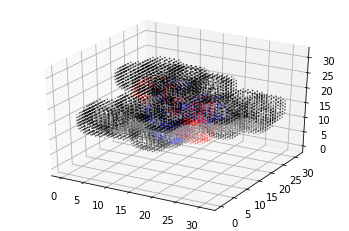

In [28]:
ax = plt.axes(projection='3d')
ax.scatter3D(x_coords , y_coords,z_coords,s=intensities,c=colors)#095)

In [3]:
pmol = PandasMol2().read_mol2('/Users/stevenagajanian/Documents/School/Grad_School/Thesis/gan/kinases/ZAP70.mol2')

In [4]:
print('Molecule ID: %s' % pmol.code)
print('\nRaw MOL2 file contents:\n\n%s\n...' % pmol.mol2_text)

Molecule ID: ZINC000026986400

Raw MOL2 file contents:

@<TRIPOS>MOLECULE
ZINC000026986400
64    67    1     0     0
SMALL
USER_CHARGES
@<TRIPOS>ATOM
1      C1     -1.4779    1.2205   -0.6895 C.3      1 ZINC000026986400   -0.1700
2      C2     -1.2415   -0.2875   -0.5843 C.3      1 ZINC000026986400   -0.1500
3      C3     -0.5332   -0.7820   -1.8471 C.3      1 ZINC000026986400    0.0300
4      H4      0.3810   -0.2082   -1.9991 H        1 ZINC000026986400    0.1500
5      C5     -0.1852   -2.2638   -1.6897 C.3      1 ZINC000026986400    0.0400
6      N6      0.4778   -2.7409   -2.9115 N.3      1 ZINC000026986400   -0.4800
7      C7      0.8570   -4.0697   -2.7851 C.ar     1 ZINC000026986400    0.3000
8      C8      1.5081   -4.7020   -3.8413 C.ar     1 ZINC000026986400   -0.1800
9      C9      1.8821   -6.0239   -3.7080 C.ar     1 ZINC000026986400    0.0000
10     C10     1.5895   -6.6809   -2.5065 C.ar     1 ZINC000026986400   -0.1100
11     C11     1.9708   -8.0998   -2.3140 C.ar    

In [5]:
pmol.df

,atom_id,atom_name,x,y,z,atom_type,subst_id,subst_name,charge
0,1,C1,-1.4779,1.2205,-0.6895,C.3,1,ZINC000026986400,-0.17
1,2,C2,-1.2415,-0.2875,-0.5843,C.3,1,ZINC000026986400,-0.15
2,3,C3,-0.5332,-0.7820,-1.8471,C.3,1,ZINC000026986400,0.03
3,4,H4,0.3810,-0.2082,-1.9991,H,1,ZINC000026986400,0.15
4,5,C5,-0.1852,-2.2638,-1.6897,C.3,1,ZINC000026986400,0.04
5,6,N6,0.4778,-2.7409,-2.9115,N.3,1,ZINC000026986400,-0.48
6,7,C7,0.8570,-4.0697,-2.7851,C.ar,1,ZINC000026986400,0.30
7,8,C8,1.5081,-4.7020,-3.8413,C.ar,1,ZINC000026986400,-0.18
8,9,C9,1.8821,-6.0239,-3.7080,C.ar,1,ZINC000026986400,0.00
9,10,C10,1.5895,-6.6809,-2.5065,C.ar,1,ZINC000026986400,-0.11
